Qualitative analysis
1. Retrieve text by image recall@4
2. Classify samples results as accurate and non-accurate
Do 3 and 4 for specter2-meta-full, specter2-special-token-meta-full
3. Choose 1 accurate sample
	3.1 Save image
	3.2 Display reference text
	3.3 Display top 4 text results
4. Choose 1 non-accurate sample
	4.1 Save image
	4.2 Display reference text
	4.3 Display top 4 text results

In [1]:
import io
import faiss
import numpy as np
import pandas as pd
import logging
from PIL import Image
from zipfile import ZipFile
from tqdm import tqdm
from typing import TypedDict, Optional, List, Any, Literal, Tuple
from sklearn.metrics import accuracy_score

VECTOR_DIMENSION = 512

class DatasetConfig(TypedDict):
    name: str
    encoded_data_path: str

class I2TResult(TypedDict):
    base_model: str
    variation: str
    accuracy: float
    records: pd.DataFrame

DUMMY_IMAGE = Image.fromarray(np.random.randint(255, size=(224,224,3),dtype=np.uint8))


In [2]:
data_list = [
    # DatasetConfig(name="miread-zero-shot", encoded_data_path="miread-zero-shot.parquet"),
    # DatasetConfig(name="miread-finetuned", encoded_data_path="miread-finetuned.parquet"),
    # DatasetConfig(name="miread-section", encoded_data_path="miread-section.parquet"),
    # DatasetConfig(name="miread-meta", encoded_data_path="miread-meta.parquet"),
    # DatasetConfig(name="miread-special-token-base", encoded_data_path="miread-special-token-base.parquet"),
    # DatasetConfig(name="miread-special-token-meta", encoded_data_path="miread-special-token-meta.parquet"),

    # DatasetConfig(name="roberta-zero-shot", encoded_data_path="roberta-zero-shot.parquet"),
    # DatasetConfig(name="roberta-finetuned", encoded_data_path="roberta-finetuned.parquet"),
    # DatasetConfig(name="roberta-section", encoded_data_path="roberta-section.parquet"),
    # DatasetConfig(name="roberta-meta", encoded_data_path="roberta-meta.parquet"),
    # DatasetConfig(name="roberta-special-token-base", encoded_data_path="roberta-special-token-base.parquet"),
    # DatasetConfig(name="roberta-special-token-meta", encoded_data_path="roberta-special-token-meta.parquet"),

    # DatasetConfig(name="scibert-zero-shot", encoded_data_path="scibert-zero-shot.parquet"),
    # DatasetConfig(name="scibert-finetuned", encoded_data_path="scibert-finetuned.parquet"),
    # DatasetConfig(name="scibert-section", encoded_data_path="scibert-section.parquet"),
    # DatasetConfig(name="scibert-meta", encoded_data_path="scibert-meta.parquet"),
    # DatasetConfig(name="scibert-special-token-base", encoded_data_path="scibert-special-token-base.parquet"),
    # DatasetConfig(name="scibert-special-token-meta", encoded_data_path="scibert-special-token-meta.parquet"),

    # DatasetConfig(name="specter2-zero-shot", encoded_data_path="specter2-zero-shot.parquet"),
    # DatasetConfig(name="specter2-finetuned", encoded_data_path="specter2-finetuned.parquet"),
    # DatasetConfig(name="specter2-section", encoded_data_path="specter2-section.parquet"),
    # DatasetConfig(name="specter2-meta", encoded_data_path="specter2-meta.parquet"),
    # DatasetConfig(name="specter2-special-token-base", encoded_data_path="specter2-special-token-base.parquet"),
    # DatasetConfig(name="specter2-special-token-meta", encoded_data_path="specter2-special-token-meta.parquet"),
    # DatasetConfig(name="specter2-special-token-meta-full", encoded_data_path="specter2-special-token-meta-full.parquet"),
    # DatasetConfig(name="specter2-special-token-meta-full-b192", encoded_data_path="specter2-special-token-meta-full-b192.parquet"),
    # DatasetConfig(name="specter2-meta-b192", encoded_data_path="specter2-meta-b192.parquet"),
    DatasetConfig(name="specter2-meta-b192-full", encoded_data_path="specter2-meta-full-b192.parquet"),
    DatasetConfig(name="specter2-special-token-meta-b192", encoded_data_path="specter2-special-token-meta-b192.parquet"),
]

In [3]:
def retrieve_text(index, encoded_image_list, k=4):
    search_key = np.asarray(encoded_image_list)
    faiss.normalize_L2(search_key)
    # Search
    _, ann = index.search(search_key, k=k)
    return ann

def retrieve_image(index, encoded_caption_list, k=4):
    search_key = np.asarray(encoded_caption_list)
    faiss.normalize_L2(search_key)
    # Search
    _, ann = index.search(search_key, k=k)
    return ann

def build_classifier_index(encoded_data_list: List[Any], device_type: Literal["cpu", "gpu"]):
    vectors = np.asarray(encoded_data_list)
    faiss.normalize_L2(vectors)

    # Create index
    if(device_type == "cpu"):
        index = faiss.IndexFlatL2(VECTOR_DIMENSION)
    elif(device_type == "gpu"):
        res = faiss.StandardGpuResources()
        flat_config = faiss.GpuIndexFlatConfig()
        flat_config.device = 0
        index = faiss.GpuIndexFlatL2(res, VECTOR_DIMENSION, flat_config)

    # Build classifier
    index.add(vectors)
    
    return index

def parse_concepts_2_set(concept_string: str) -> set:
    return set([token.strip() for token in concept_string.split(",")])

def calculate_set_relevance(a: set, b: set) -> float:
    a_union_b = a.union(b)
    union_len = len(a_union_b)
    if(union_len <= 0):
        logging.error("Division by 0")
        pass
    return len(a.intersection(b))/union_len if union_len > 0 and len(a) > 0 else 1

def getTextByIndex(df: pd.DataFrame, index_list: List[int]) -> List[str]:
    result_list = list()
    for index in index_list:
        result_list.append(df[df["index"] == index].iloc[0]["original_caption"])
    return result_list

def load_image_from_zip(image_zip: ZipFile, filename: str) -> Tuple[bool, Image.Image | None]:
    try:
        img_file = image_zip.read(filename)
        img = Image.open(io.BytesIO(img_file)).convert("RGB")
        return True, img
    except:
        return False, DUMMY_IMAGE

def getImageByIndex(df: pd.DataFrame, image_zip: ZipFile, index_list: List[int]) -> List[Image.Image]:
    image_list = list()
    for index in index_list:
        target_record = df[df["index"] == index].iloc[0]
        image_list.append(load_image_from_zip(image_zip, target_record["image_path"])[1])
    return image_list

In [4]:
def evaluate_data(base_input_path: str, data_config: DatasetConfig, batch_size: int, data_size_limit: int=0, relevance_metric: Literal["identity", "section", "concepts"] = "identity") -> I2TResult:
    '''
    Expected columns : 'index', 'raw_index', 'document_id', 'caption', 'original_image_path',
       'image_type', 'first_level_dir', 'second_level_dir', 'section',
       'journal_name', 'article_title', 'subjects', 'authors', 'image_path',
       'new_section', 'concepts', 'original_caption', 'encoded_caption',
       'encoded_image', 'load_status'
    '''

    # Load encoded data as dataframe
    records = pd.read_parquet("{}/{}".format(base_input_path, data_config["encoded_data_path"]), engine="pyarrow")
    records = records.reset_index().rename(columns={"index":"raw_index"}).reset_index()

    
    if(data_size_limit != 0):
        records = records.iloc[:data_size_limit]

    # Filter records without concepts
    # records = records[records["concepts"] != ""]

    DATA_SIZE = records.shape[0]
    
    logging.debug("Records with blank concepts: {} / {}".format(records[records["concepts"] == ""].shape[0], DATA_SIZE))

    # Divide records into batches
    batches = [list(range(i, i+batch_size)) if i+batch_size < DATA_SIZE else list(range(i, DATA_SIZE)) for i in range(0, DATA_SIZE, batch_size)]

    # Create indexes
    index = build_classifier_index(list(records["encoded_caption"]), device_type="gpu")

    retrieve_text_indices = list()

    for _, batch in tqdm(enumerate(batches), total=len(batches)): #enumerate(batches):#
        encoded_image_list = list(records.iloc[batch[0]:batch[-1]+1]["encoded_image"])
        retrieved_text = retrieve_text(index=index, encoded_image_list=encoded_image_list, k=4)
        retrieve_text_indices.extend(retrieved_text)

    records["i2t-result"] = retrieve_text_indices
    records["match_top_1"] = records.apply(lambda row: row["index"] == row["i2t-result"][0], axis=1)
    records["i2t-top-1"] = records.apply(lambda row: row["i2t-result"][0], axis=1)
    records["i2t-top-1-section"] = records.apply(lambda row: records.iloc[row["i2t-top-1"]]["new_section"], axis=1)
    records["i2t-top-1-concepts"] = records.apply(lambda row: records.iloc[row["i2t-top-1"]]["concepts"], axis=1)

    # print(records[["index", "raw_index", "i2t-result", "match_top_1", "i2t-top-1"]].head(8))
    # print("{} : {:.4f}".format(data_config["name"], accuracy_score(records["index"], records["i2t-top-1"])))
    
    name_tokens = data_config["name"].split("-")

    accuracy = 0
    if(relevance_metric == "identity"):
        accuracy = accuracy_score(records["index"], records["i2t-top-1"])
    elif(relevance_metric == "section"):
        accuracy = accuracy_score(records["new_section"], records["i2t-top-1-section"])
    elif(relevance_metric == "concepts"):
        accuracy = sum(records.apply(lambda row: calculate_set_relevance(parse_concepts_2_set(row["concepts"]), parse_concepts_2_set(row["i2t-top-1-concepts"])), axis=1)) / DATA_SIZE
    else:
        raise NotImplementedError("Unknown Relevance metric")

    result = I2TResult(
        base_model=name_tokens[0],
        variation="-".join(name_tokens[1:]),
        accuracy=accuracy,
        records=records
    )

    return result

In [5]:
base_input_path = "/home/horton/datasets/meta-scir/encoded_data/test"
# output_path = "/home/horton/datasets/meta-scir/information-retrieval"

# Initialize log file

print("Test Accuracy : {}".format(accuracy_score([1], [1])))
metric_list = ("identity", "section", "concepts", ) # "concepts" 
result_list = list()
metric="identity"
print("Metric : {}".format(metric))
result_list = list()
for data_config in data_list:
    result_dict = evaluate_data(
        base_input_path=base_input_path, 
        data_config=data_config, 
        batch_size=512,
        data_size_limit=0,
        relevance_metric=metric
    )
    result_list.append(result_dict)

Test Accuracy : 1.0
Metric : identity


100%|██████████| 140/140 [00:00<00:00, 436.25it/s]


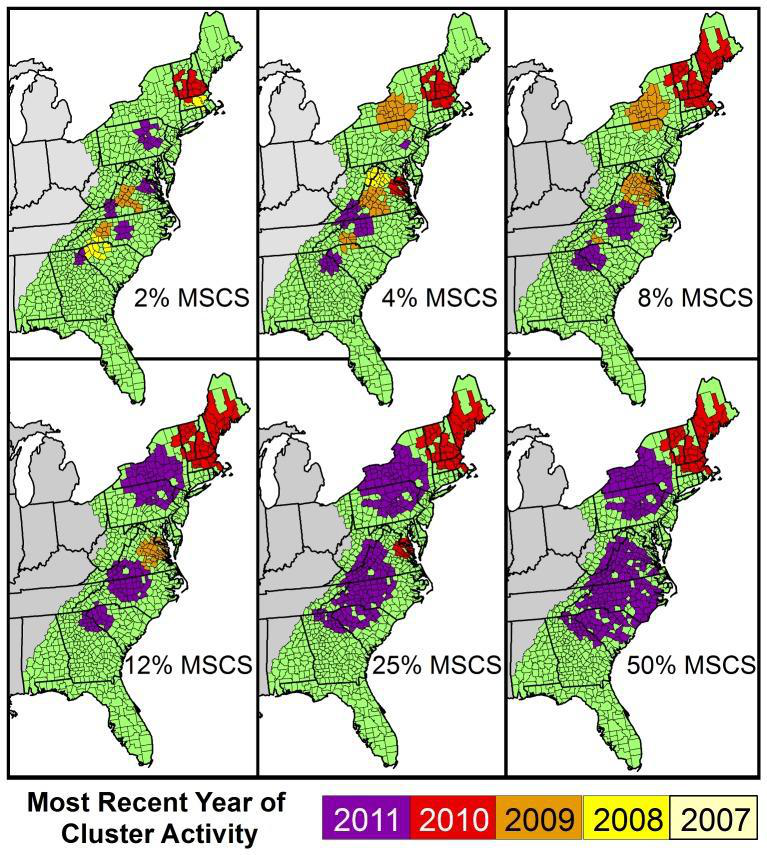

Original Caption : Clusters of High Rates of Raccoon Variant Cross Species Transmission over Varying Spatial Cluster Values, 20072011.

Accurate Result : False



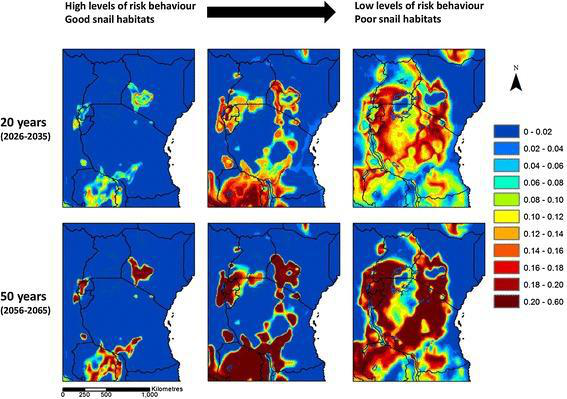

Relative risk of new foci of transmission developing, using the moderate warming climate projection. Results are for 20262035 relative to 20062015 (top) and 20562065 relative to 20062015 (bottom). Blue colours indicate little or no risk. Red colours indicate high risk. The maps on the left show risk in villages with high levels of risk behaviour and good snail habitats. The maps on the right show risk in villages with lower levels of risk behaviour and/or poor snail habitats. The key indicates the proportion of cut-offs that were crossed between baseline and 20 and 50years time. Results for the low and high warming scenarios are shown in the Additional file : Figures S2 and Additional file : Figure S3.



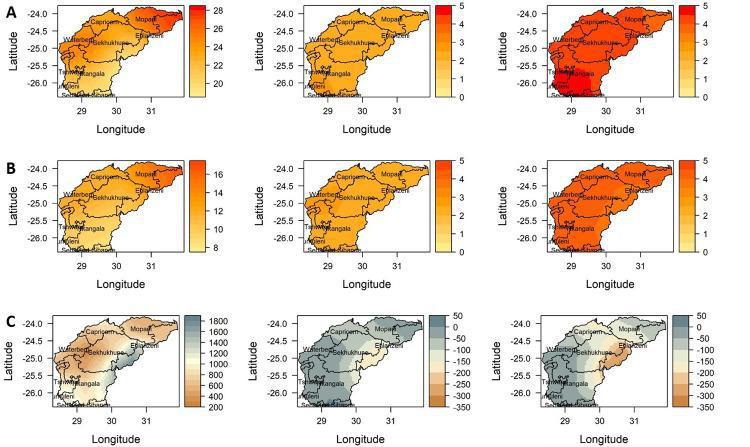

Projected changes in annual (A) mean maximum, (B) minimum temperature and (C) total rainfall, for 20362065 (2nd column) and 20662095 (3rd column) periods under scenarios of the RCP8.5 relative to the baseline period 19762005 (1st column) over the Olifants River Catchment. "Basemap (Water management shapefile was collected from the South Africa National Department of Water and Sanitation on



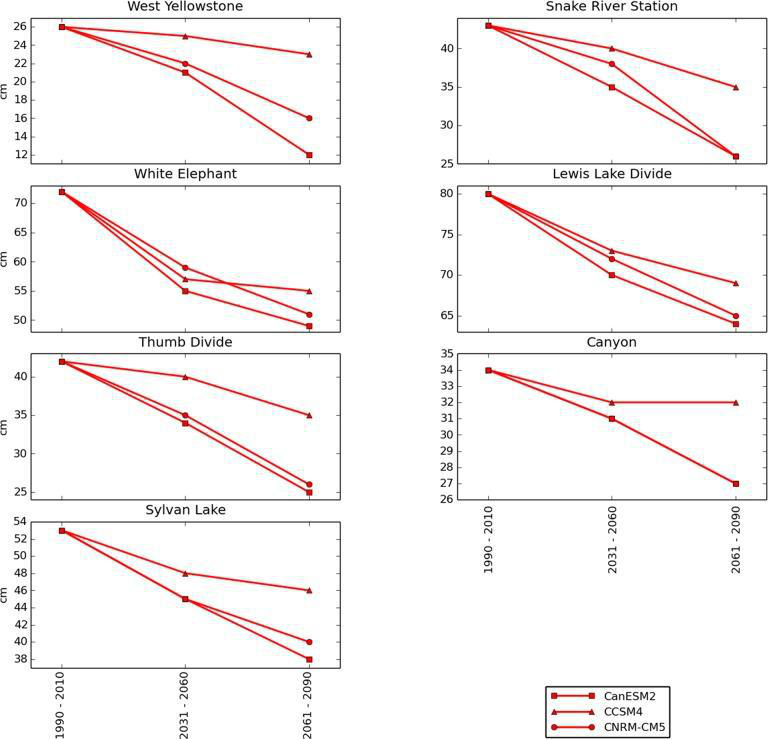

Median annual peak SWE for 7 SNOTEL locations under the RCP 8.5 scenario.Historical (19902010) medians are calculated from historical SNOTEL weather station data. Mid- and late- 21



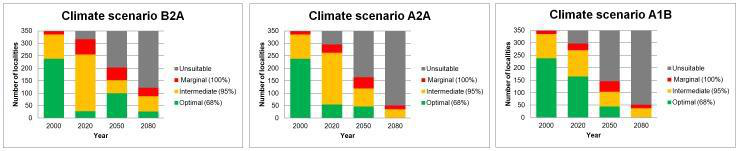

Locality analysis overview I.Predicted climate change outcomes for indigenous Arabica localities for the year interval 2000, 2020, 2050 and 2080. Stacked bar-charts based on . Green=optimal [bioclimatic] localities (68%); yellow=intermediate (suboptimal) [bioclimatic] localities (95%); red=marginal (extreme) [bioclimatic] localities (100%); grey=unsuitable bioclimatic localities.



/tmp/ipykernel_165175/2311106717.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


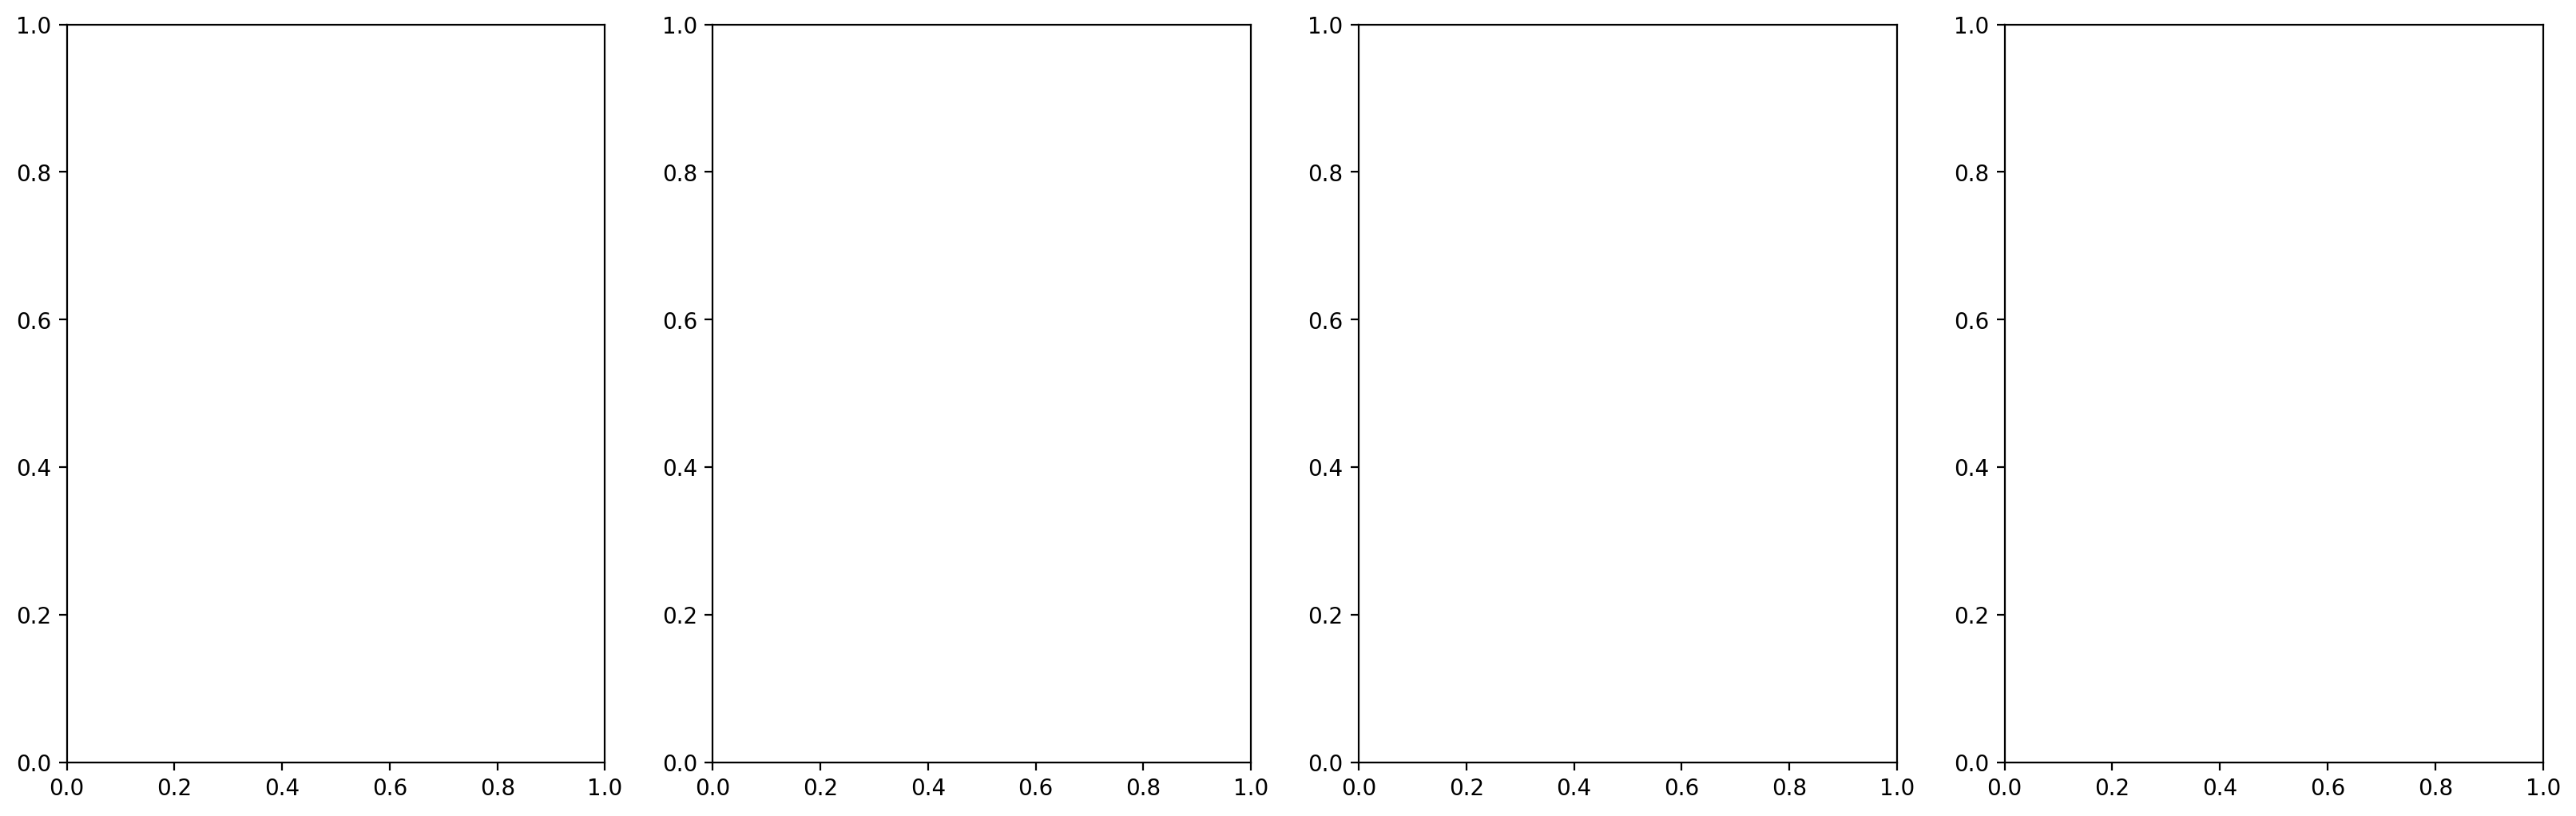

In [6]:
import matplotlib.pyplot as plt
target_records = result_list[0]["records"]

image_zip_path = "/home/horton/datasets/meta-scir/dataset-meta-special-token/test.zip"

image_zip = ZipFile(image_zip_path, "r")

def showResult(target_records: pd.DataFrame, target_index: int):
    target_record = target_records.iloc[target_index]

    image = load_image_from_zip(image_zip, target_record["image_path"])

    image[1].show()
    top_4_text = getTextByIndex(target_records, target_record["i2t-result"])
    top_4_image = getImageByIndex(target_records, image_zip, target_record["i2t-result"])
    print("Original Caption : {}".format(target_record["original_caption"]), end="\n\n")
    print("Accurate Result : {}".format(target_record["match_top_1"]), end="\n\n")
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), dpi=200)
    for rank, (text, image) in enumerate(zip(top_4_text, top_4_image)):
        # ax[rank].imshow(image)
        # ax[rank].set_title = f"RANK : {rank + 1}"
        # ax[rank].get_xaxis().set_visible(False)
        # ax[rank].get_yaxis().set_visible(False)
        image.show()
        print(text, end="\n\n")
    fig.show()
    return

# False
showResult(target_records, 1)

# True 71523
# showResult(target_records, 71523)



In [7]:
target_records[target_records["match_top_1"]]["new_section"]

7        results and discussion
11       results and discussion
12       results and discussion
15                      methods
24       results and discussion
                  ...          
71523    results and discussion
71530    results and discussion
71540    results and discussion
71552    results and discussion
71560    results and discussion
Name: new_section, Length: 12289, dtype: object

### Retrieve Image with arbitrary caption

In [8]:
import io
import torch
import pandas as pd
from typing import TypedDict, Literal, List, Tuple
from zipfile import ZipFile
from PIL import Image
from transformers import (
    VisionTextDualEncoderProcessor,
    AutoModel,
    AutoTokenizer,
    CLIPImageProcessor,
)
import numpy as np
from tqdm import tqdm
from pathlib import Path

class ModelConfig(TypedDict):
    name: str
    model_path: str
    model_type: Literal["PLAIN", "SECTION", "META", "SPECIAL-TOKEN-META"]

model_list = [
    ModelConfig(name="specter2-special-token-meta-b192", model_path="/home/horton/datasets/meta-scir/models/specter2-special-token-meta-b192", model_type="SPECIAL-TOKEN-META")
]

def load_model(model_config: ModelConfig):
    tokenizer = AutoTokenizer.from_pretrained(model_config["model_path"])
    image_processor = CLIPImageProcessor.from_pretrained(model_config["model_path"])

    model = AutoModel.from_pretrained(model_config["model_path"])
    processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

    return model, processor

def load_image_classifer_index(base_input_path, data_config):
    # Load encoded data as dataframe
    records = pd.read_parquet("{}/{}".format(base_input_path, data_config["encoded_data_path"]), engine="pyarrow")
    records = records.reset_index().rename(columns={"index":"raw_index"}).reset_index()

    # Create indexes
    index = build_classifier_index(list(records["encoded_image"]), device_type="gpu")

    return records, index

def load_caption_classifer_index(base_input_path, data_config):
    # Load encoded data as dataframe
    records = pd.read_parquet("{}/{}".format(base_input_path, data_config["encoded_data_path"]), engine="pyarrow")
    records = records.reset_index().rename(columns={"index":"raw_index"}).reset_index()

    # Create indexes
    index = build_classifier_index(list(records["encoded_caption"]), device_type="gpu")

    return records, index


/home/horton/miniconda3/envs/faiss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model, processor = load_model(model_list[0])
records, index = load_image_classifer_index(base_input_path, data_config) 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
def get_enhanced_caption(title, concepts, section, caption):
    """
    title = ""
    concepts = "" #comma separated
    section = ""
    caption = ""
    """
    enhanced_caption = f"[START-TITLE] {title} [END-TITLE] [START-CONCEPT] {concepts} [END-CONCEPT] [START-SECTION] {section} [END-SECTION] {caption}"
    return enhanced_caption

def encode_data(model, processor, text_list, image_list=None):
    model = model.to(device)
    if(image_list is None):
        image_list = [DUMMY_IMAGE]
    with torch.no_grad():
        inputs = processor(text=text_list, images=image_list, return_tensors="pt", padding=True)
        inputs = inputs.to(device)
        inputs["input_ids"] = inputs["input_ids"][:,:512]
        # print(inputs["input_ids"].shape)
        inputs["attention_mask"] = inputs["attention_mask"][:,:512]
        outputs = model(**inputs)
    return np.asarray(outputs.text_embeds.to("cpu")), np.asarray(outputs.image_embeds.to("cpu"))

[7, 11, 12, 15, 24, 32, 34, 35, 41, 53]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
results and discussion
fs and nstransient absorption (TA) data, i.e., transient spectra at selected delay times and kinetic traces at certain probe wavelengths (450, 500 and 620nm), of Ru (a and d), RuH


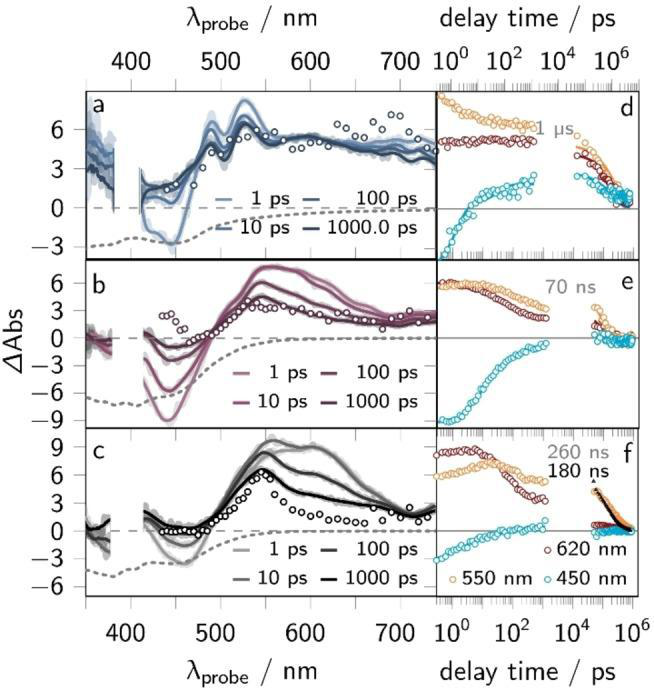

[START-TITLE] scholary document processing [END-TITLE] [START-CONCEPT]  [END-CONCEPT] [START-SECTION] introduction [END-SECTION] bar charts
[START-TITLE] scholary document processing [END-TITLE] [START-CONCEPT]  [END-CONCEPT] [START-SECTION] methods [END-SECTION] bar charts
[START-TITLE] scholary document processing [END-TITLE] [START-CONCEPT]  [END-CONCEPT] [START-SECTION] results and discussion [END-SECTION] bar charts
[START-TITLE] scholary document processing [END-TITLE] [START-CONCEPT]  [END-CONCEPT] [START-SECTION] conclusion [END-SECTION] bar charts
[START-TITLE] scholary document processing [END-TITLE] [START-CONCEPT]  [END-CONCEPT] [START-SECTION] other [END-SECTION] bar charts


In [12]:
positive_samples = target_records[target_records["match_top_1"] == True]
negative_samples = target_records[target_records["match_top_1"] == False]

print(list(positive_samples["index"])[:10])
print(list(negative_samples["index"])[:10])

image_zip_path = "/home/horton/datasets/meta-scir/dataset-meta-special-token/test.zip"

image_zip = ZipFile(image_zip_path, "r")

target_record = records.iloc[7]
_, img = load_image_from_zip(image_zip, target_record["image_path"])


print(target_record["new_section"])
print(target_record["original_caption"])
img.show()


caption_records = list()

POSSIBLE_SECTIONS = ["introduction", "methods", "results and discussion", "conclusion", "other"]

title = "scholary document processing"
concepts = ""
caption = "bar charts"#"neural network model for contrastive learning for image representation"
# Western blot, barcharts

for section in POSSIBLE_SECTIONS:
    caption_records.append(get_enhanced_caption(title, concepts, section, caption))

for c in caption_records:
    print(c)

encoded_text_list, _ = encode_data(model, processor, caption_records, None)

image_result = retrieve_image(index, encoded_text_list, k=4)


/tmp/ipykernel_165175/528655847.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


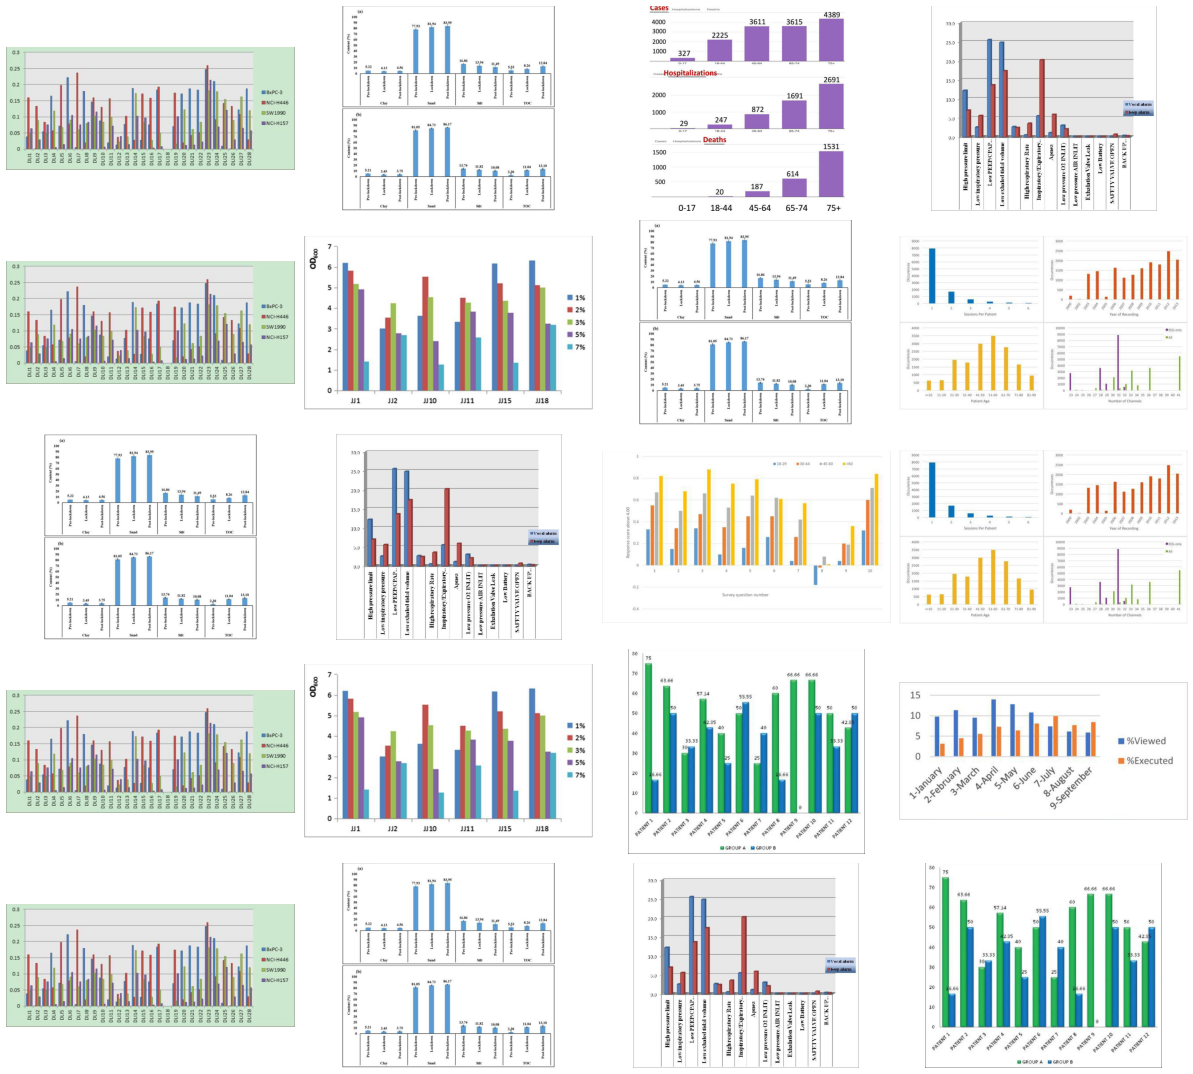

In [13]:
image_list = list()
for i in range(5):
    image_list.append(getImageByIndex(records, image_zip, image_result[i]))

# print(image_list)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 18), dpi=60)
for i in range(5):
    for j in range(4):
        ax[i][j].imshow(image_list[i][j])
        ax[i][j].axis(False)
            
    
    # ax[rank].set_title = f"RANK : {rank + 1}"
        # ax[rank].get_xaxis().set_visible(False)
        # ax[rank].get_yaxis().set_visible(False)
    # image.show()
fig.tight_layout()
fig.show()


800 336
(3, 512) (4, 512)
0 : bar chart
1 : western blot
2 : microscopy
[array([0.12825869, 0.11996652, 0.14814763, 0.11500332], dtype=float32), array([0.60669416, 0.60608673, 0.15771592, 0.15766342], dtype=float32), array([ 0.05169301,  0.10002763, -0.08159976, -0.15089658], dtype=float32)]

1 1 
1 1 


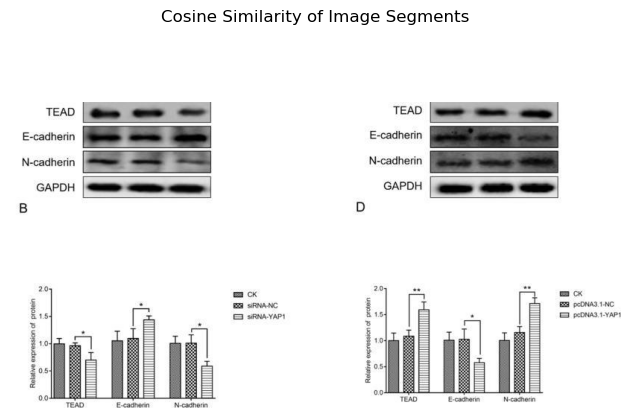

In [33]:
import math

img = image_list[0][0]
img = Image.open("/home/horton/datasets/meta-scir/test_segment_02.jpg")

img = img.crop(box = (0, 120, 800, 456))

def analyze_img_segments(img: Image.Image, display_option: Literal["label", "cosine_sim"], v_ratio=4, h_ratio=4):
    w, h = img.size
    print(w, h)
    v_segment_size = math.ceil(h/v_ratio)
    v_segments = int(math.ceil(h/v_segment_size))
    h_segment_size = math.ceil(w/h_ratio)
    h_segments = int(math.ceil(w/h_segment_size))

    image_segment_list = list()

    for r in range(v_segments):
        row_segment_list = list()
        for c in range(h_segments):
            left = c * h_segment_size
            top = r * v_segment_size
            right = left + h_segment_size
            bottom = top + v_segment_size
            img_segment = img.crop((left, top, right, bottom))
            row_segment_list.append(img_segment)
        image_segment_list.append(row_segment_list)

    fig, ax = plt.subplots(nrows=v_segments, ncols=h_segments) #, figsize=(16, 20), dpi=40

    fig.suptitle("Cosine Similarity of Image Segments")
    
    for r in range(v_segments):
        for c in range(h_segments):
            ax[r][c].imshow(image_segment_list[r][c])
            # ax[r][c].get_xaxis().set_visible(False)
            # ax[r][c].get_yaxis().set_visible(False)
            ax[r][c].axis(False)
            
    fig.tight_layout()

    flat_image_list = list()
    for i in range(v_segments):
        flat_image_list.extend(image_segment_list[i])

    # bar charts
    t_e, i_e = encode_data(model, processor, ["bar chart", "western blot", "microscopy"], flat_image_list)
    print(t_e.shape, i_e.shape)
    s_all = list()
    for i in range(3):
        scores = np.sum(t_e[i, :] * i_e, axis=1)
        s_all.append(scores)
        
    most_likely_match = np.argmax(np.asarray(s_all), axis=0)

    print("0 : bar chart")
    print("1 : western blot")
    print("2 : microscopy")
    print(s_all)

    mlm = list()

    if(display_option == "label"):
        for i in range(most_likely_match.shape[0]):
            if(i % h_segments == 0):
                print()
                mlm.append(list())
            mlm[int(i/h_segments)].append(most_likely_match[i])
            print(most_likely_match[i], end=" ")
        print()
    elif(display_option == "cosine_sim"):
        for i in range(most_likely_match.shape[0]):
            if(i % h_segments == 0):
                print()
            print(round(s_all[0][i], ndigits=3), end=" ")
        print()

    return v_segments, h_segments, image_segment_list, mlm

v_segments, h_segments, image_segment_list, mlm = analyze_img_segments(img, display_option="label", v_ratio=2, h_ratio=2)

[[1, 1], [1, 1]]


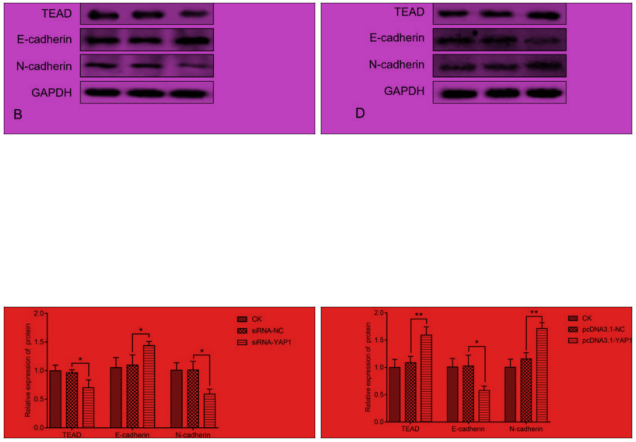

In [34]:
print(mlm)
def colorCode(img, label):
    r, g, b = img.split()
    r_modifier = 1
    g_modifier = 1
    b_modifier = 1

    dim = 0.5

    if(label == 0):
        r_modifier = 1.75 * dim
        g_modifier = 0.25 * dim
        b_modifier = 0.25 * dim
    elif(label == 1):
        r_modifier = 1.5 * dim
        g_modifier = 0.5 * dim
        b_modifier = 1.5 * dim
    elif(label == 2):
        r_modifier = 0.75
        g_modifier = 0.75
        b_modifier = 1.5
    modified_r = r.point(lambda x: x * r_modifier)
    modified_g = g.point(lambda x: x * g_modifier)
    modified_b = b.point(lambda x: x * b_modifier)
    
    return Image.merge("RGB", (modified_r, modified_g, modified_b))

for r in range(v_segments):
    for c in range(h_segments):
        image_segment_list[r][c] = colorCode(image_segment_list[r][c], mlm[r][c])

fig, ax = plt.subplots(nrows=v_segments, ncols=h_segments, figsize=(16, 20), dpi=40)

for r in range(v_segments):
    for c in range(h_segments):
        ax[r][c].imshow(image_segment_list[r][c])
        ax[r][c].get_xaxis().set_visible(False)
        ax[r][c].get_yaxis().set_visible(False)

fig.tight_layout()

In [16]:
a = np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4]])
a = 1/a
a

array([[1.        , 0.5       , 0.33333333, 0.25      ],
       [1.        , 0.5       , 0.33333333, 0.25      ],
       [1.        , 0.5       , 0.33333333, 0.25      ]])

In [17]:
import pandas as pd

# df = pd.read_parquet("train.parquet", engine="pyarrow")

categories = dict()

categories["computer graphics"] = 1

categories["biology"] = 2

# for record in df.to_dict(orient="records"):
#     # Split keywords
#     concepts = map(lambda a: a.strip(),record["concepts"].split(","))
#     for c in concepts:
#         if(c in categories):
#             categories[c] += 1
#         else:
#             categories[c] = 1

concept_count_list = categories.items()
sorted(concept_count_list,key=lambda x: x[1], reverse=True)

# 
# Biology : 4985110
# Medicine : 4491188
# Internal medicine : 2569825
# Gene : 2460790
# Genetics : 2343883
# Chemistry : 2188888
# Biochemistry : 2177591
# Computer science : 1410770
# Cell biology : 1321690
# Pathology : 1285765
#  : 1080620
# Physics : 1078136
# Immunology : 1065306
# Materials science : 906193
# Organic chemistry : 862290
# Surgery : 756550
# Engineering : 753091
# Cancer research : 742268
# Psychology : 727614
# Cancer : 716193
# Endocrinology : 697431
# Ecology : 680287
# Mathematics : 679949
# Neuroscience : 677086
# Disease : 647321

[('biology', 2), ('computer graphics', 1)]